In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from jupyterthemes import jtplot
jtplot.style(grid=False)

from wrangle import wrangle_semicon
from prepare import split_semicon, scale_data_minmax

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from prepare import get_metrics, rfe

# Analyzing and predicting IC chip failure
- Project in creating a classification model to predict if an IC wafer will pass or fail (%yield spec) after the manufacturing process
- A single 300mm silicon wafer may contain hundreds/thousands of microchip die
- Data is downloaded from UCI http://archive.ics.uci.edu/ml/datasets/SECOM
- The main challenge is to narrow down 591 features for use in predictive modeling

# Key findings:
- Defect rate only 7% so data heavily skewed towards passing 
- Not enough observations within a 4 month period for a good predictive model
- 591 features narrowed down to 181

# Data acquisition and prep
- Secom Data and labels downloaded from UCI site
- 591 features, no descriptions given just numbers. Target is "Defect"
- columns with > 20% null values dropped
- since all original feature columns are float, nulls filled with mean values
- columns with standard deviation of 0 removed
- After scaling,pair columns with > 90% correlation to eachother had the latter pair dropped
- Columns with < 0.3 coefficient of variance were dropped. Values not deviating much from the mean
- Month extracted from timestamp and made its own column

In [2]:
df = wrangle_semicon()
df.head()

,3,4,6,12,14,15,16,17,21,28,31,32,33,34,35,40,41,43,44,46,48,51,55,59,63,64,65,67,71,74,77,78,79,80,83,84,89,103,114,117,119,122,124,125,126,129,131,132,133,134,135,136,137,138,139,142,143,144,145,146,150,151,153,155,156,159,160,161,162,163,166,167,168,169,170,171,172,175,176,177,180,181,182,183,184,185,187,188,195,198,200,201,202,203,205,208,210,211,212,213,214,215,216,217,218,219,221,222,223,224,225,227,228,238,239,248,250,251,253,254,255,267,268,269,316,367,368,412,418,419,423,430,432,433,438,439,460,468,472,473,474,476,480,482,483,484,485,486,487,488,489,496,499,500,510,511,521,542,543,544,546,548,549,550,551,555,558,559,560,562,563,564,565,572,573,582,583,586,587,589,date,time,defect
0,1411.1265,1.3602,97.6133,202.4396,7.9558,414.8710,10.0433,0.9680,-5419.00,64.2333,3.5191,83.3971,9.5126,50.6170,64.2588,61.29,4.515,352.7173,10.1841,723.3092,141.2282,218.3174,2834.0,-1.7264,16.1445,21.7264,29.5367,0.9226,84.0793,0.0,0.0141,-0.0307,-0.0083,-0.0026,7.2163,0.1320,0.1841,-0.0042,0.0,58.4306,0.9804,2.639,15.93,0.8656,3.353,-0.0473,0.9960,2.2967,1000.7263,39.2373,123.0,111.3,75.2,46.2000,350.6710,6.78,0.0034,0.0898,0.0850,0.0358,4.271,10.284,0.0167,0.41,0.0506,1017.0,967.0,1066.0,368.0,0.090,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.9499,0.3979,0.160,20.95,0.333,12.49,16.713,0.0803,5.72,11.19,65.363,0.292,0.296,10.30,5.38,4.040,16.230,8.64,97.314,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,0.0707,0.0211,175.2173,0.0315,1940.3994,0.0744,0.0546,0.0027,0.0040,0.0188,219.9453,0.0011,0.0189,0.0050,0.4269,0.0472,40.855,4.5152,6.2698,0.0124,0.0114,24.8504,525.0965,0.0000,53.6840,18.7673,26.3617,49.0013,44.5055,42.2737,29.9394,311.6377,63.7987,24.7625,13.6778,31.9893,115.7408,613.3069,291.4842,494.6996,178.1759,843.1138,0.0000,53.1098,0.0000,17.1202,0.0000,0.0000,64.6707,0.0000,0.0,0.1096,0.0078,0.0026,1.0616,75.752,0.4234,12.93,0.78,39.8842,1.0344,0.4385,0.1039,262.729683,0.679641,6.444985,0.14561,8.95,0.3157,0.5005,0.0118,0.021458,0.016475,99.670066,19/07/2008,11:55:00,0
1,1463.6606,0.8294,102.3433,200.5470,10.1548,414.7347,9.2599,0.9701,-5441.50,68.4222,3.4171,84.9052,9.7997,50.6596,64.2828,78.25,2.773,352.2445,10.0373,724.8264,145.8445,205.1695,2853.0,0.8073,10.9036,19.1927,27.6301,1.1598,82.3494,0.0,0.0004,-0.0440,-0.0358,-0.0120,6.8043,0.1358,0.1874,-0.0045,0.0,58.6680,0.9731,2.541,15.88,0.8703,2.771,-0.0946,0.9985,2.2932,998.1081,37.9213,98.0,80.3,81.0,56.2000,219.7679,5.70,0.0049,0.1356,0.0600,0.0547,6.285,13.077,0.0144,0.35,0.0437,568.0,59.0,297.0,3277.0,0.112,2.2,1.1,0.079,0.561,1.0498,0.1917,0.4115,1.0181,0.2315,0.325,17.99,0.439,10.14,16.358,0.0892,6.92,9.05,82.986,0.222,0.316,8.02,3.74,3.659,15.078,8.96,134.250,0.0566,0.0488,0.1651,0.1578,0.0468,0.0987,0.0734,0.0747,3.9578,0.0050,0.0761,0.0014,128.4285,0.0238,1988.0000,0.0203,0.0236,0.0064,0.0036,0.0154,193.0287,0.0007,0.0187,0.0086,0.5749,0.0411,29.743,3.6327,5.6522,0.0081,0.0033,15.0150,0.0000,368.9713,61.8918,10.4383,8.4887,199.7866,48.5294,37.5793,40.4475,463.2883,73.5536,19.4865,13.2430,30.8643,163.0249,0.0000,246.7762,0.0000,359.0444,130.6350,820.7900,194.4371,0.0000,12.6788,0.0000,0.0000,141.4365,0.0000,0.0,0.1096,0.0078,0.0026,1.3526,74.640,0.7193,16.00,1.33,53.1836,0.9634,0.1745,0.0375,262.729683,0.679641,6.444985,0.14561,5.92,0.2653,0.5019,0.0223,0.009600,0.020100,208.204500,19/07/2008,12:32:00,0
2,1698.0172,1.5102,95.4878,202.0179,9.5157,416.7075,9.3144,0.9674,-5447.75,67.1333,3.5986,84.7569,8.6590,50.1530,64.1114,14.37,5.434,364.3782,9.8783,734.7924,141.0845,185.7574,2936.0,23.8245,11.3019,16.1755,24.2829,0.8694,84.7681,0.0,-0.0052,0.0213,-0.0054,-0.1134,7.1041,0.1362,0.1497,-0.0026,0.0,58.4808,0.9772,2.882,15.95,0.8798,3.094,-0.1892,0.9978,2.2592,998.4440,42.0579,89.0,126.4,96.5,45.1001,306.0380,8.33,0.0038,0.0754,0.0483,0.0619,4.819,8.443,0.0177,0.47,0.0497,562.0,788.0,759.0,2100.0,0.187,2.1,1.4,0.123,0.319,1.0824,0.0369,0.3141,0.9677,0.2706,0.326,17.78,0.745,13.31,22.912,0.1959,9.21,17.87,60.110,0.139,0.949,16.73,5.09,11.059,22.624,

In [3]:
#narrowed down to 183 features
df.shape

(1567, 183)

# Features are 591 signals/measurements during chip manufacturing. Their names are hidden to protect the manufacturing process. Narrowed down to 183

array([[<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'21'}>,
        <AxesSubplot:title={'center':'28'}>,
        <AxesSubplot:title={'center':'31'}>,
        <AxesSubplot:title={'center':'32'}>,
        <AxesSubplot:title={'center':'33'}>],
       [<AxesSubplot:title={'center':'34'}>,
        <AxesSubplot:title={'center':'35'}>,
        <AxesSubplot:title={'center':'40'}>,
        <AxesSubplot:title={'center':'41'}>,
        <AxesSubplot:title={'center':'43'}>,
        <AxesSubplot:title={'center':'44'}>,
        <AxesSubplot:title={'center':'46'}>,
        <AxesSubplot:title={'center':'48'}>,
        <AxesSubplot:title={'center':'51'}>,
        <Axe

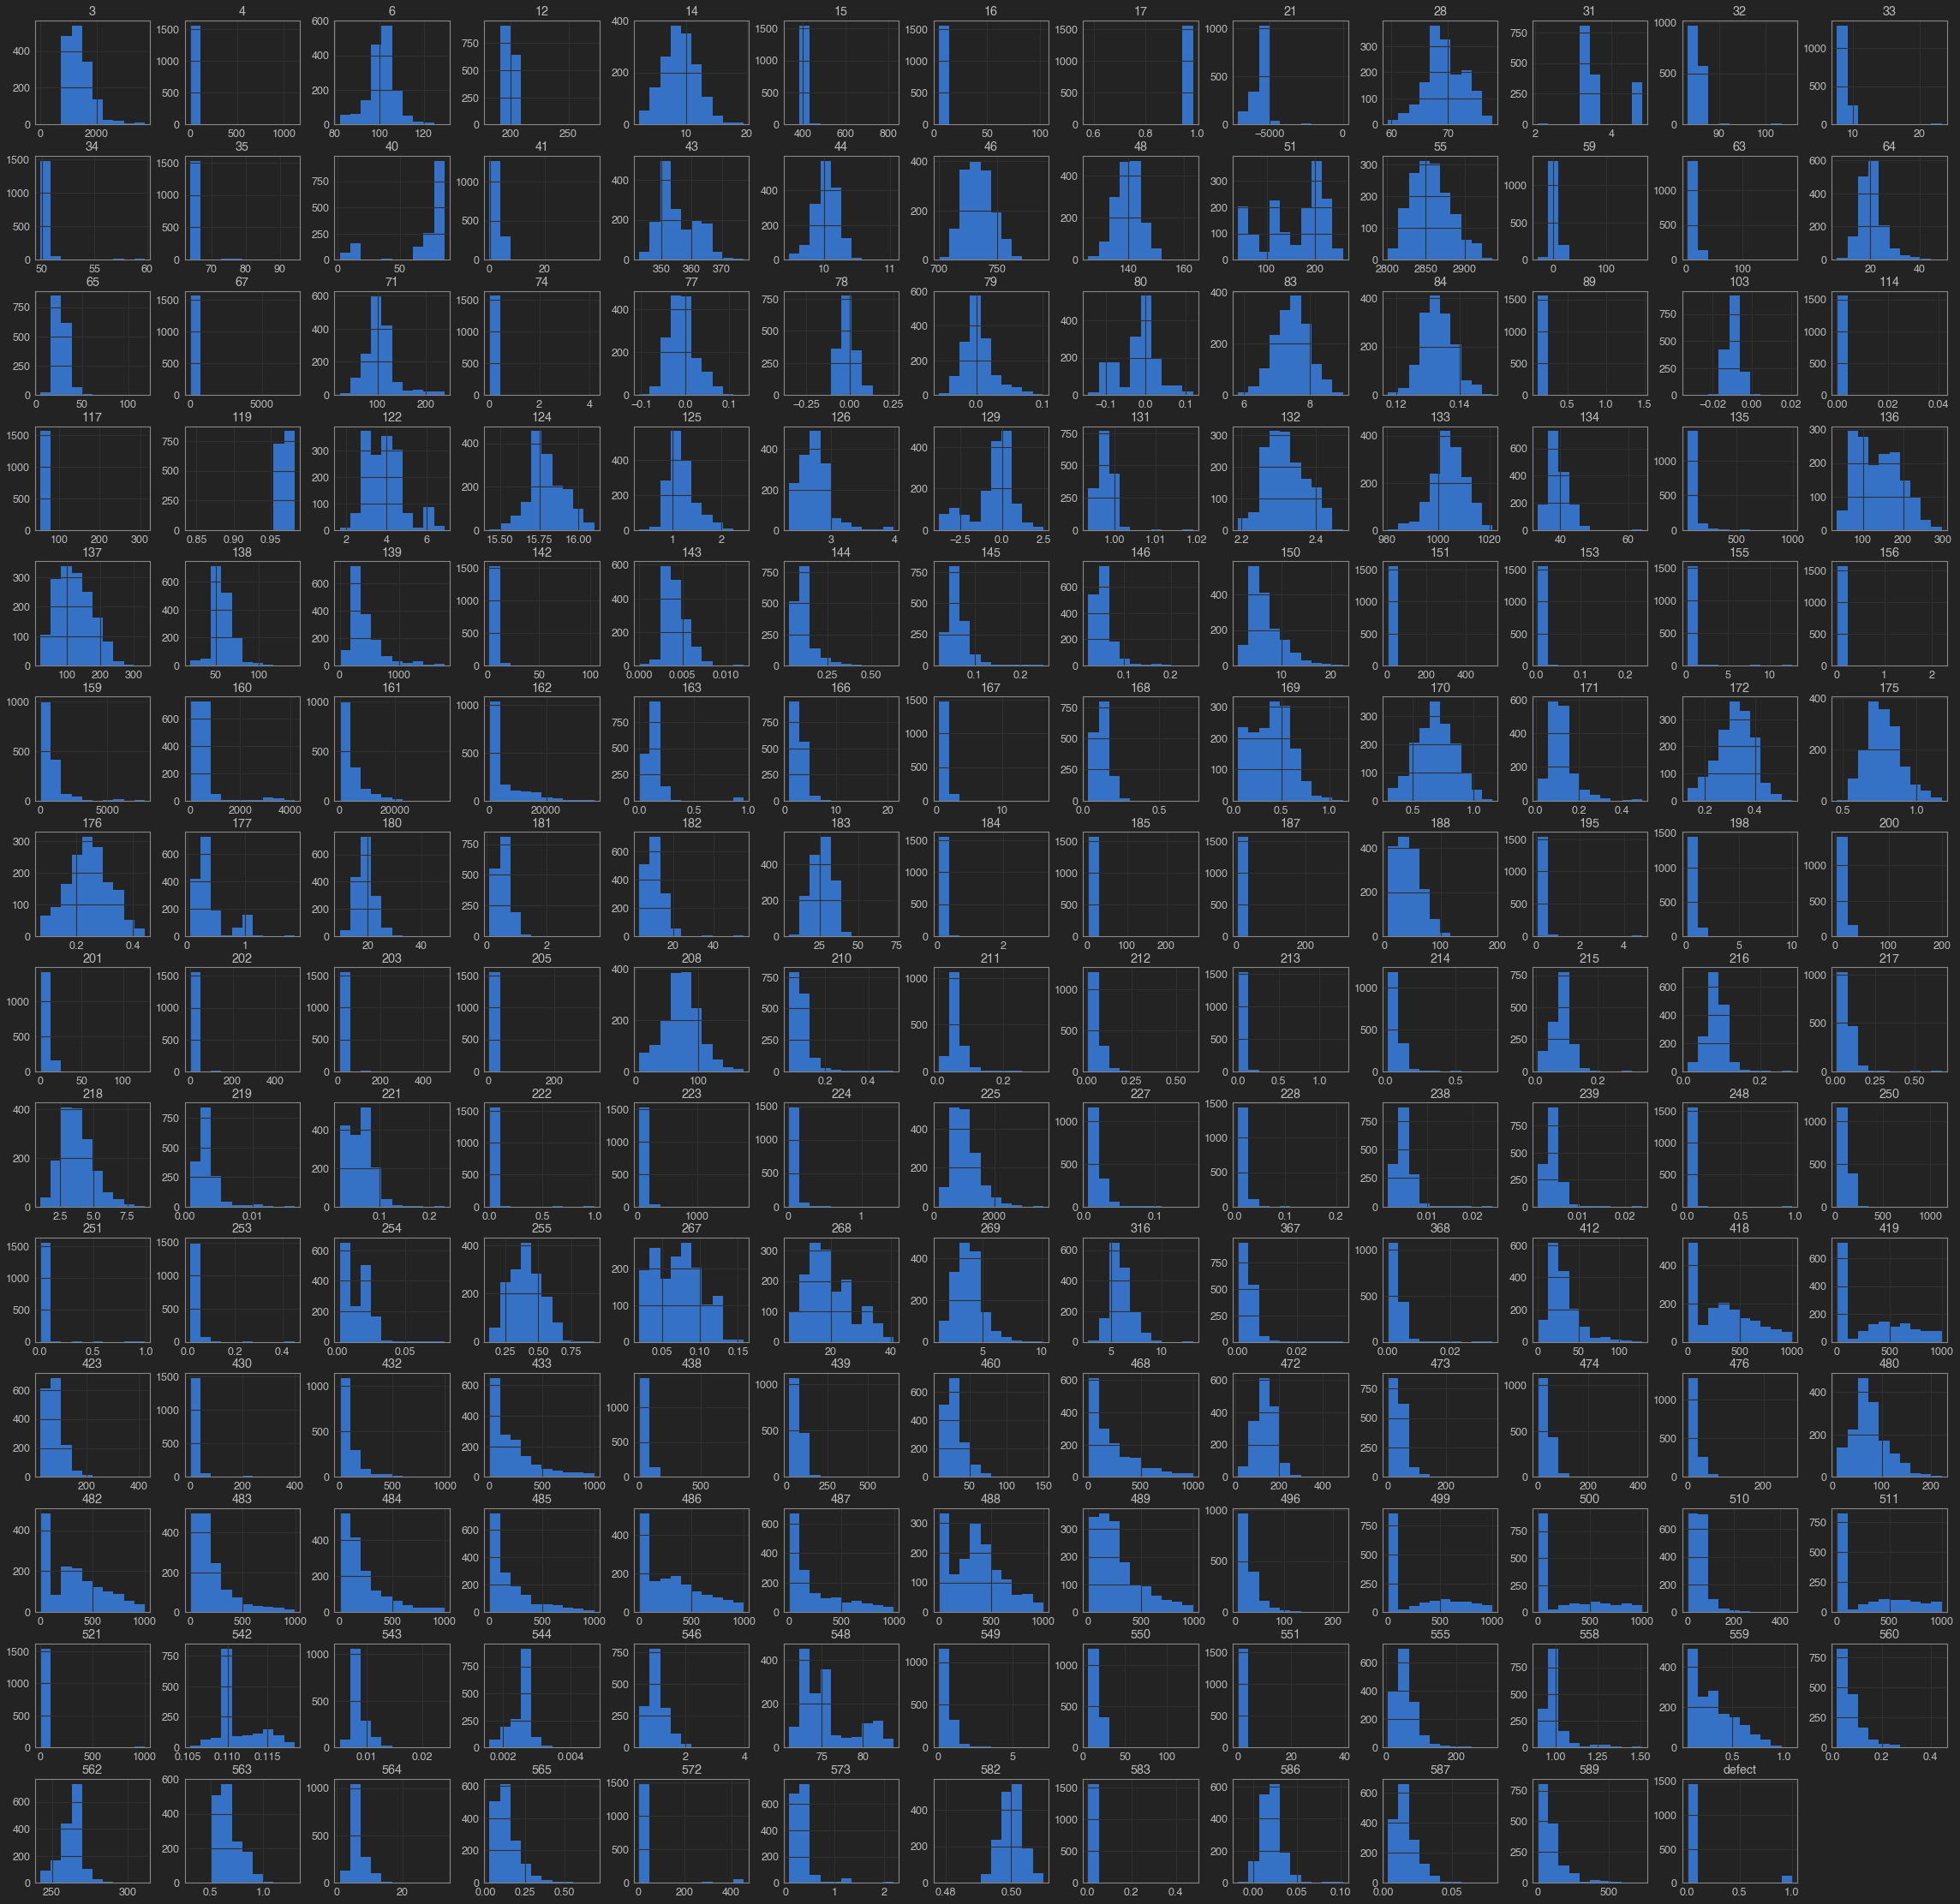

In [4]:
#quick overview of sensor/measurement distributions
df.hist(figsize=[40,40])

In [5]:
# 7% defective rate
df.defect.value_counts()

0    1463
1     104
Name: defect, dtype: int64

In [6]:
#observations count by month. July - Oct 2008
split_date= df.date.str.split('/',expand=True)
split_date[1].value_counts()

09    590
08    555
10    359
07     63
Name: 1, dtype: int64

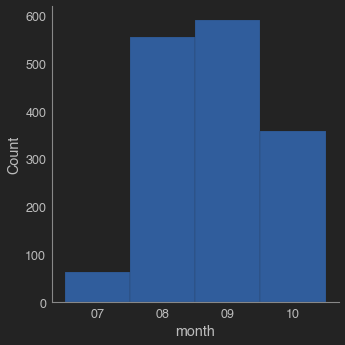

In [7]:
#observations per month
df['month'] = split_date[1]
sns.displot(data=df.month)

# Univariate takeaways:
- a lot of the features are skewed to the right
- observations are skewed to the left by month. The bulk of observations are after July.

In [8]:
#splitting for bivariate stratified by target
train, validate, test = split_semicon(df, stratify_by='defect')
train.shape, validate.shape, test.shape

((877, 184), (376, 184), (314, 184))

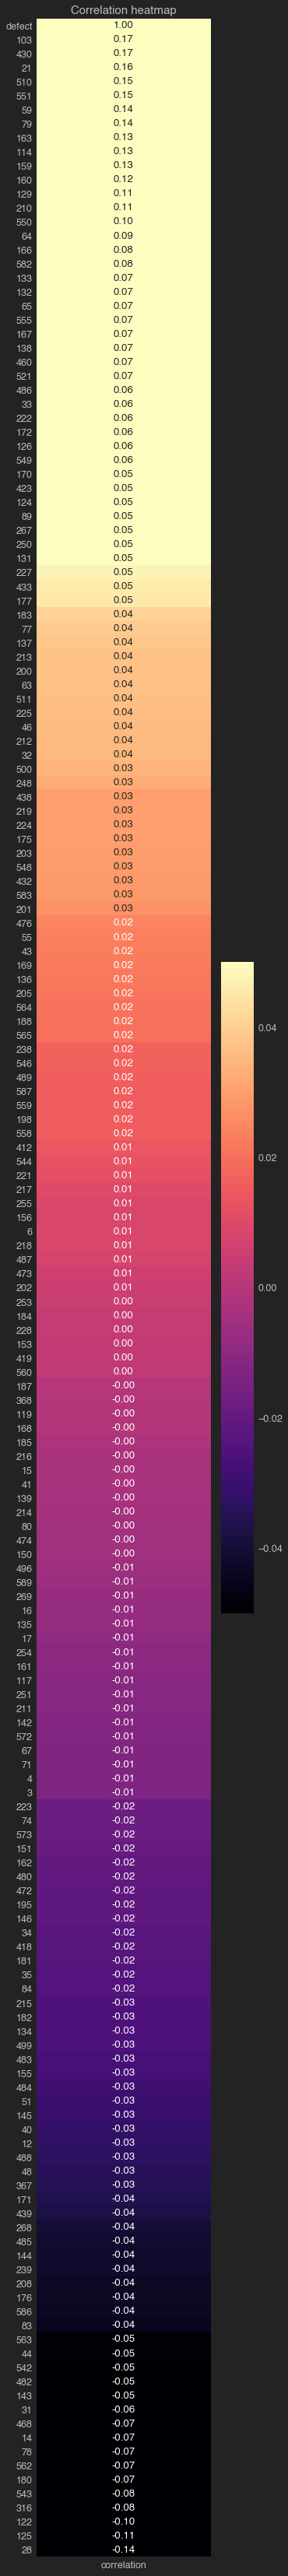

In [9]:
# Correlation heatmap. Target is not continuous so I wouldn't expect much correlation
corr = pd.DataFrame(train.corr()['defect'].sort_values(ascending = False)).rename(columns = {'defect':'correlation'})
jtplot.style()
plt.figure(figsize = (5,60))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'magma')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

In [10]:
#defects grouped by month. 
pd.DataFrame(train.groupby('month')['defect'].value_counts())

defect
month defect        
07    0           25
      1            7
08    0          265
      1           30
09    0          337
      1           12
10    0          192
      1            9

<AxesSubplot:xlabel='month', ylabel='defect'>

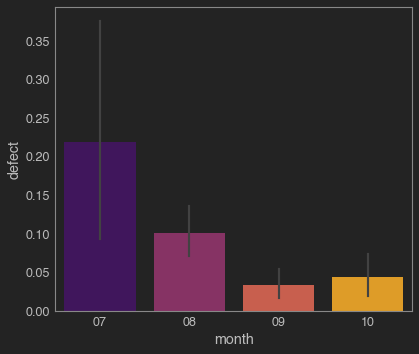

In [11]:
#average defects per month
jtplot.style(grid=False)
sns.barplot(x = train['month'], y = train['defect'],palette='inferno',order=['07','08','09','10'])

# Bivariate takeaways:
- seems like July and August have higher defect rates than Sept/Oct
- Need statistical test to determine if defect rate of July/August is significant to add as a feature
- Probably not enough observations for statistical testing but try anyway

# Is the mean defect rate significantly different for July/August than Sept/Oct?

In [ ]:
#scaling using min max scaler
train_scaled, validate_scaled, test_scaled = scale_data_minmax(train.drop(columns=['date', 'time', 'month']),validate.drop(columns=['date', 'time', 'month']),
                                                                                        test.drop(columns=['date', 'time', 'month']))

In [12]:
#subsetting july/aug and sept/oct
july_aug = train[train.month.isin(['07','08'])].defect
sept_oct = train[train.month.isin(['09','10'])].defect

In [13]:
null_hypothesis = "The mean defect rates are the same between July/Aug and Sept/Oct"
alternative_hypothesis = "The mean defect rates are significantly different between July/Aug and Sept/Oct"
confidence_level = .95
a = 1 - confidence_level

In [14]:
#mann whitney u
t, p = stats.mannwhitneyu(july_aug,sept_oct) 
t, p

(83183.5, 7.903524795068647e-06)

In [15]:
if p < a:
    print('We reject the null')
    print('We move forward with the alternative hypothesis acknowledging that the mean defect rates between July/Aug and Sept/Oct are significantly different')
else:
    print("we fail to reject the null")

We reject the null
We move forward with the alternative hypothesis acknowledging that the mean defect rates between July/Aug and Sept/Oct are significantly different


# Baseline accuracy 93%

In [16]:
#mode of actual target observations
train.defect.value_counts()

0    819
1     58
Name: defect, dtype: int64

In [17]:
train['baseline_prediction'] = 0
train.head(1)

,3,4,6,12,14,15,16,17,21,28,31,32,33,34,35,40,41,43,44,46,48,51,55,59,63,64,65,67,71,74,77,78,79,80,83,84,89,103,114,117,119,122,124,125,126,129,131,132,133,134,135,136,137,138,139,142,143,144,145,146,150,151,153,155,156,159,160,161,162,163,166,167,168,169,170,171,172,175,176,177,180,181,182,183,184,185,187,188,195,198,200,201,202,203,205,208,210,211,212,213,214,215,216,217,218,219,221,222,223,224,225,227,228,238,239,248,250,251,253,254,255,267,268,269,316,367,368,412,418,419,423,430,432,433,438,439,460,468,472,473,474,476,480,482,483,484,485,486,487,488,489,496,499,500,510,511,521,542,543,544,546,548,549,550,551,555,558,559,560,562,563,564,565,572,573,582,583,586,587,589,date,time,defect,month,baseline_prediction
870,1242.842,1.4083,99.2178,202.9766,6.6826,395.9674,10.341,0.959,-5451.75,70.7778,3.3851,87.1883,9.0145,50.0471,64.1861,78.27,3.075,350.3927,10.2542,725.6465,139.7009,125.4432,2851.0,2.4209,14.3253,17.5791,22.2504,1.1001,104.6959,0.0,0.0473,0.0049,0.0009,0.0517,7.6143,0.1448,0.1992,-0.0112,0.0,59.0937,0.9806,3.636,15.82,0.9838,2.857,-0.1419,0.9972,2.3984,1015.5056,40.1991,132.0,211.6,173.2,54.6001,398.835,5.98,0.0032,0.1127,0.0607,0.0504,3.821,12.144,0.0266,0.28,0.0298,596.0,343.0,2586.0,782.0,0.04,3.0,1.3,0.186,0.274,0.4776,0.0723,0.383,0.6765,0.1388,1.108,20.18,0.474,16.7,32.835,0.1138,8.09,20.26,33.996,0.344,1.227,25.91,17.15,20.831,32.002,9.46,96.603,0.0669,0.0516,0.0746,0.0205,0.074,0.0958,0.0447,0.0222,3.0338,0.0015,0.0511,0.0014,128.1179,0.0332,1045.4004,0.0118,0.0125,0.0043,0.0069,0.0175,121.2332,0.001,0.027,0.0038,0.2142,0.1578,13.91,2.187,5.915,0.0025,0.0024,32.0906,502.1717,417.1754,57.178,10.9323,60.5798,0.0,54.1667,91.4255,27.1007,708.4114,180.8688,97.559,93.6209,27.3764,92.2701,432.1356,352.8205,157.7167,416.2437,0.0,185.2998,69.9804,19.9595,16.6826,0.0,0.0,38.2222,0.0,0.0,0.1091,0.0141,0.003,0.5771,72.812,0.3101,21.81,0.71,53.7363,1.1069,0.6043,0.1588,261.262,0.911,1.49,0.1335,8.72,0.2363,0.5006,0.0113,0.0117,0.0262,223.1018,17/09/2008,02:01:00,0,09,0


In [18]:
#accuracy
baseline_accuracy = (train.defect == train.baseline_prediction).mean()
baseline_accuracy

0.9338654503990877

In [19]:
#dropping before modeling
train.drop(columns='baseline_prediction',inplace=True)

# Feature Engineering
- RFECV

In [20]:
#adding feature
train['is_July_Aug'] = train.month.apply(lambda x: 1 if x in ['07','08'] else 0)
validate['is_July_Aug'] = validate.month.apply(lambda x: 1 if x in ['07','08'] else 0)
test['is_July_Aug'] = test.month.apply(lambda x: 1 if x in ['07','08'] else 0)

In [21]:
#using min max scaler
train_scaled, validate_scaled, test_scaled = scale_data_minmax(train.drop(columns=['date', 'time', 'month']),validate.drop(columns=['date', 'time', 'month']),
                                                                                        test.drop(columns=['date', 'time', 'month']))
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((877, 182), (376, 182), (314, 182))

In [22]:
#splitting target
X_train = train_scaled.drop(columns='defect')
y_train = train.defect

X_validate = validate_scaled.drop(columns='defect')
y_validate = validate.defect

X_test = test_scaled.drop(columns='defect')
y_test = test.defect

In [23]:
# Recursive feature engineering with cross validation
logit = LogisticRegression(C=1, class_weight='balanced',
                           random_state=123,solver='liblinear')

rfecv = RFECV(estimator=logit, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=1, class_weight='balanced',
                                   random_state=123, solver='liblinear'),
      scoring='accuracy')

In [24]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 156


# 156 optimal # of features according to RFECV.....

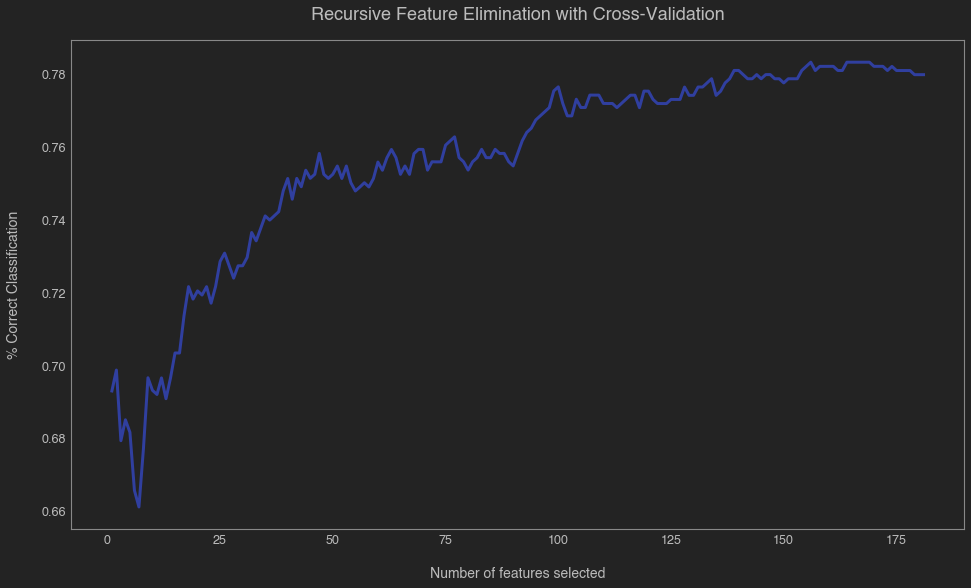

In [25]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [26]:
#features based on rfe and optimal number of features from rfecv
logit_cols = rfe(X_train, y_train, 156)

# Logistic regression MVP model

In [27]:
#splitting features and target 156 features based on logistic reg RFECV
X_train = train_scaled[logit_cols]
y_train = train.defect

X_validate = validate_scaled[logit_cols]
y_validate = validate.defect

X_test = test_scaled[logit_cols]
y_test = test.defect

In [28]:
#creating and fitting logistic reg model
logit = LogisticRegression(C=1, class_weight='balanced',
                           random_state=123,solver='liblinear', max_iter=1000)

model= logit.fit(X_train, y_train)

#training data report
log_report = get_metrics(model,X_train,y_train)
log_report

confusion matrix: 
 [[680 139]
 [  3  55]]


    The accuracy for our model is 0.8381
    The True Positive Rate is 0.948, The False Positive Rate is 0.17,
    The True Negative Rate is 0.83, and the False Negative Rate is 0.0517
    


,precision,recall,f1-score,support
0,0.995608,0.830281,0.905459,819.000000
1,0.283505,0.948276,0.436508,58.000000
accuracy,0.838084,0.838084,0.838084,0.838084
macro avg,0.639556,0.889278,0.670984,877.000000
weighted avg,0.948513,0.838084,0.874445,877.000000


In [29]:
#validate data report
log_report_validate = get_metrics(model,X_validate,y_validate)
log_report_validate

confusion matrix: 
 [[274  77]
 [ 15  10]]


    The accuracy for our model is 0.7553
    The True Positive Rate is 0.4, The False Positive Rate is 0.219,
    The True Negative Rate is 0.781, and the False Negative Rate is 0.6
    


,precision,recall,f1-score,support
0,0.948097,0.780627,0.856250,351.000000
1,0.114943,0.400000,0.178571,25.000000
accuracy,0.755319,0.755319,0.755319,0.755319
macro avg,0.531520,0.590313,0.517411,376.000000
weighted avg,0.892701,0.755319,0.811192,376.000000


In [30]:
#test data report
log_report_test = get_metrics(model, X_test,y_test)
log_report_test

confusion matrix: 
 [[246  47]
 [ 13   8]]


    The accuracy for our model is 0.8089
    The True Positive Rate is 0.381, The False Positive Rate is 0.16,
    The True Negative Rate is 0.84, and the False Negative Rate is 0.619
    


,precision,recall,f1-score,support
0,0.949807,0.839590,0.891304,293.000000
1,0.145455,0.380952,0.210526,21.000000
accuracy,0.808917,0.808917,0.808917,0.808917
macro avg,0.547631,0.610271,0.550915,314.000000
weighted avg,0.896013,0.808917,0.845775,314.000000


### MVP Logistic model 80% accuracy and 38% recall on test data

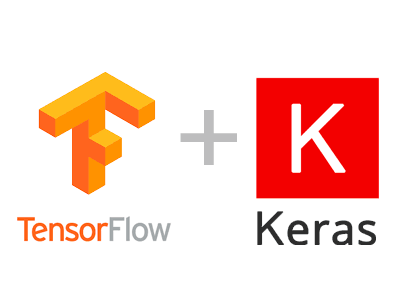

In [230]:
from IPython import display
display.Image("./tensorflow.png")

--------
# Tensorflow Keras neural network classification model

In [31]:
#resetting features to 181 total
X_train = train_scaled.drop(columns='defect')
y_train = train.defect

X_validate = validate_scaled.drop(columns='defect')
y_validate = validate.defect

X_test = test_scaled.drop(columns='defect')
y_test = test.defect

In [49]:
X_train.shape, y_train.shape

((877, 181), (877,))

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

In [34]:
#evaluation metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [223]:
#creating 3 layer neural network
model = keras.Sequential([
    #keras.layers.Flatten(input_shape=(1,181)),
    keras.layers.Dense(25, activation=tf.nn.relu),
    keras.layers.Dense(25, activation=tf.nn.relu), 
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [224]:
#compiling model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [225]:
#fitting model on training data
model.fit(X_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
28/28 [==============================] - 1s 1ms/step - loss: 0.5067 - acc: 0.8403 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2309 - acc: 0.9411 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2927 - acc: 0.9166 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2622 - acc: 0.9265 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2547 - acc: 0.9283 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2102 - acc: 0.9457 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 7/100
28/28 [=========

In [226]:
#metric names
model.metrics_names

['loss', 'acc', 'f1_m', 'precision_m', 'recall_m']

In [227]:
#train metrics
loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=0)
print('\nTrain accuracy:', round(accuracy, 2))
print('Train precision:', round(precision, 2))
print('Train recall:', round(recall, 2))
print('Train F1:', round(f1_score, 2))


Train accuracy: 1.0
Train precision: 0.93
Train recall: 0.93
Train F1: 0.93


In [228]:
#validate metrics
loss, accuracy, f1_score, precision, recall = model.evaluate(X_validate, y_validate, verbose=0)
print('\nValidate accuracy:', round(accuracy,2))
print('Validate precision:', round(precision,2))
print('Validate recall:',round(recall,2))
print('Validate F1:', round(f1_score, 2))


Validate accuracy: 0.91
Validate precision: 0.11
Validate recall: 0.07
Validate F1: 0.08


In [229]:
#test metrics
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', round(accuracy,2))
print('Test precision:', round(precision,2))
print('Test recall:', round(recall,2))
print('Test F1:', round(f1_score, 2))


Test accuracy: 0.93
Test precision: 0.28
Test recall: 0.18
Test F1: 0.22


# Modeling takeaways
- probably need to narrow down features some more from 181
- MVP logistic model doesn't meet baseline accuracy 80% acc 38% recall
- Tensorflow Keras model overfit. Accuracy is > 90% but recal and precision are terrible

# Conclusion
- Analysis on defect rate inconclusive
- There are plent of features but not enough observations to create a predictive model that beats a baseline accuracy of 93%
- Hard to narrow down out of 591 features the most important ones
- Keras sequential model overfit
- Next steps, experiment with other models, narrow down features from 181